In [1]:
import time 
import copy 
import os 
import torch 
from torch.utils.data import Dataset 
from torchvision import transforms 
from torch.utils.data import DataLoader 
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import vgg19, vgg19_bn
import cv2
from PIL import Image
import numpy as np
from scipy import misc
import shutil
from google.colab import drive
from torch.optim import lr_scheduler
from torchsummary import summary
import sys
from tqdm import tqdm
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # setting the device 
drive.mount('/content/drive',force_remount=True)
os.chdir('/content/drive/My Drive')
import random

Mounted at /content/drive


In [2]:
EPSILON = 1e-15

class TableNet(nn.Module):
    """TableNet."""
    def __init__(self, num_class: int, batch_norm: bool = False): 
        """Initialize TableNet.
        Args:
            num_class (int): Number of classes per point.
            batch_norm (bool): Select VGG with or without batch normalization.
        """
        super().__init__()
        self.vgg = vgg19(pretrained=True).features if not batch_norm else vgg19_bn(pretrained=True).features
        self.layers = [18, 27] if not batch_norm else [26, 39]
        self.model = nn.Sequential(nn.Conv2d(512, 512, kernel_size=1),
                                   nn.ReLU(inplace=True),
                                   nn.Dropout(0.8),
                                   nn.Conv2d(512, 512, kernel_size=1),
                                   nn.ReLU(inplace=True),
                                   nn.Dropout(0.8))
        self.table_decoder = TableDecoder(num_class)
        self.column_decoder = ColumnDecoder(num_class)

    def forward(self, x):
        """Forward pass.
        Args:
            x (tensor): Batch of images to perform forward-pass.
        Returns (Tuple[tensor, tensor]): Table, Column prediction.
        """
        results = []
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            if i in self.layers:
                results.append(x)
        x_table = self.table_decoder(x, results)
        x_column = self.column_decoder(x, results)
        return torch.sigmoid(x_table), torch.sigmoid(x_column)


class ColumnDecoder(nn.Module):
    """Column Decoder."""

    def __init__(self, num_classes: int):
        """Initialize Column Decoder.
        Args:
            num_classes (int): Number of classes per point.
        """
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.8),
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=True),
        )
        self.layer = nn.ConvTranspose2d(1280, num_classes, kernel_size=2, stride=2, dilation=1)

    def forward(self, x, pools):
        """Forward pass.
        Args:
            x (tensor): Batch of images to perform forward-pass.
            pools (Tuple[tensor, tensor]): The 3 and 4 pooling layer from VGG-19.
        Returns (tensor): Forward-pass result tensor.
        """
        pool_3, pool_4 = pools
        x = self.decoder(x)
        x = F.interpolate(x, scale_factor=2)
        x = torch.cat([x, pool_4], dim=1)
        x = F.interpolate(x, scale_factor=2)
        x = torch.cat([x, pool_3], dim=1)
        x = F.interpolate(x, scale_factor=2)
        x = F.interpolate(x, scale_factor=2)
        return self.layer(x)


class TableDecoder(ColumnDecoder):
    """Table Decoder."""

    def __init__(self, num_classes):
        """Initialize Table decoder.
        Args:
            num_classes (int): Number of classes per point.
        """
        super().__init__(num_classes)
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=True),
        )


class DiceLoss(nn.Module):
    """Dice loss."""

    def __init__(self):
        """Dice Loss."""
        super().__init__()

    def forward(self, inputs, targets, smooth=1):
        """Calculate loss.
        Args:
            inputs (tensor): Output from the forward pass.
            targets (tensor): Labels.
            smooth (float): Value to smooth the loss.
        Returns (tensor): Dice loss.
        """
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice


def binary_mean_iou(inputs, targets):
    """Calculate binary mean intersection over union.
    Args:
        inputs (tensor): Output from the forward pass.
        targets (tensor): Labels.
    Returns (tensor): Intersection over union value.
    """
    output = (inputs > 0).int()

    if output.shape != targets.shape:
        targets = torch.squeeze(targets, 1)

    intersection = (targets * output).sum()

    union = targets.sum() + output.sum() - intersection

    result = (intersection + EPSILON) / (union + EPSILON)

    return result

In [3]:
class MarmotDataset(Dataset):
    """Marmot Dataset."""

    #def __init__(self, data: List[Path], transforms: Compose = None) -> None:
    def __init__(self, imgs_path, column_label,table_label, transform=None):
        """Marmot Dataset initialization.
        Args:
            data (List[Path]): A list of Path.
            transforms (Optional[Compose]): Compose object from albumentations.
        """
        self.transform = transform
        self.imgs_path = imgs_path  
        self.column_mask_path = column_label    
        self.table_mask_path = table_label   

    def __len__(self):
        """Dataset Length."""
        return len(os.listdir(self.imgs_path))

    def __getitem__(self, item):
        """Get sample data.
        Args:
            item (int): sample id.
        Returns (Tuple[tensor, tensor, tensor]): Image, Table Mask, Column Mask
        """
        sample_id = os.listdir(self.imgs_path)[item]

        image_path = self.imgs_path + sample_id
        table_path = self.table_mask_path + sample_id
        column_path = self.column_mask_path + sample_id

        image = np.array(Image.open(image_path))
        table_mask = np.expand_dims(np.array(Image.open(table_path)), axis=2)
        column_mask = np.expand_dims(np.array(Image.open(column_path)), axis=2)
        #mask = np.concatenate([table_mask, column_mask], axis=2) / 255
        sample = {"image": image, "column_mask": column_mask, "table_mask":table_mask }
        if self.transform:
            sample["image"] = self.transform(image)
            sample["column_mask"] = self.transform(column_mask)
            sample["table_mask"] = self.transform(table_mask)

        image = sample["image"]
        mask_table = sample["table_mask"] #sample["mask"][:, :, 0]#.unsqueeze(0)
        mask_column = sample["column_mask"] #sample["mask"][:, :, 1]#.unsqueeze(0)
        #print("im here")
        #print(mask.shape)
        #print(image.shape,mask_table.shape,mask_column.shape)
        return image, mask_table, mask_column

In [5]:
## Marmot dataset dataloaders

save_path = '/content/drive/My Drive/Abinbev/marmot_data/weights/'

marmot_train_dataset = MarmotDataset(
        imgs_path='/content/drive/My Drive/Abinbev/marmot_data/Marmot_data/',        
        column_label='/content/drive/My Drive/Abinbev/marmot_data/column_mask/',
        table_label = '/content/drive/My Drive/Abinbev/marmot_data/table_mask/',
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((450,450))
            ]),
            )

marmot_testset = MarmotDataset(
        imgs_path='/content/drive/My Drive/Abinbev/marmot_data/marmot_val/',        
        column_label='/content/drive/My Drive/Abinbev/marmot_data/column_mask/',
        table_label = '/content/drive/My Drive/Abinbev/marmot_data/table_mask/',
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((450,450))
            ]),
            )

In [6]:
## custom dataset dataloaders

train_dataset = MarmotDataset(
        imgs_path='/content/drive/My Drive/Abinbev/marmot_data/invoice_data/',        
        column_label='/content/drive/My Drive/Abinbev/marmot_data/invoice_column_mask/',
        table_label = '/content/drive/My Drive/Abinbev/marmot_data/invoice_table_mask/',
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((450,450))
            ]),
            )

testset = MarmotDataset(
        imgs_path='/content/drive/My Drive/Abinbev/marmot_data/invoice_val/',        
        column_label='/content/drive/My Drive/Abinbev/marmot_data/invoice_column_mask/',
        table_label = '/content/drive/My Drive/Abinbev/marmot_data/invoice_table_mask/',
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((450,450))
            ]),
            )

In [7]:
t=train_dataset[2]
img = t[0]
mask_table = t[1]
mask_column = t[2]

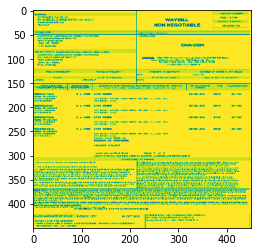

In [8]:
plt.imshow(img[0])

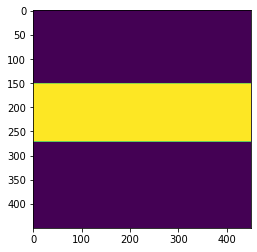

In [9]:
plt.imshow(mask_table[0])

In [11]:
### IF you MESS up this code there is a BACKUP one in the BOTTOM of the page check it OUT

loss_list = {'train':[],'val':[]}
def train(epo_num, batch_size, lr, save_path):
    dataloader = {'train':DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2),'val':DataLoader(testset, batch_size=batch_size,shuffle=True, num_workers=2)}
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    table_model = TableNet(1)
    table_model.load_state_dict(torch.load(save_path+'model_dice_loss40.pkl'))
    #table_model.load_state_dict(torch.load(save_path+'model_dice_loss_invoice,40,120.pkl'))
    table_model = table_model.to(device)
    criterion = DiceLoss().to(device)#nn.BCEWithLogitsLoss().to(device)
    #criterion = soft_dice_loss().to(device)
    #optimizer = optim.SGD(lung_model.parameters(), lr=lr, momentum=0.99)
    optimizer = optim.Adam(table_model.parameters(), lr, (0.9, 0.999), eps=1e-08, weight_decay=5e-4)
    #optimizer = optim.AdamW(lung_model.parameters(), weight_decay=1e-5, amsgrad=True)
    exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    global_index = 0
    for epo in range(epo_num):
        start_time = time.time() 
        exp_lr_scheduler.step()
        for phase in ['train','val']:
          running_loss = 0  
          if phase == 'train':
            start_time = time.time()
            table_model.train()
          else:
            start_time = time.time()
            table_model.eval()
          print("-----------------"+phase+"---------------------")

          for index, (img, table_mask,column_mask) in enumerate(dataloader[phase],0):
              img = img.float()
              img = img.to(device)
              table_mask=transforms.Resize((448,448)).forward(table_mask)
              column_mask=transforms.Resize((448,448)).forward(column_mask)
              #table_mask = cv2.resize(table_mask[0], (896,896))
              #column_mask = cv2.resize(column_mask[0], (896,896))

              table_mask = table_mask.to(device)
              column_mask = column_mask.to(device)
              #print(column_mask.shape)
              optimizer.zero_grad()

              with torch.set_grad_enabled(phase == 'train'):
                output = table_model(img)
                #output = torch.sigmoid(output)
                out_table = output[0]
                out_column = output[1]        
                #print(out_table.shape)
                loss = criterion(out_table,table_mask) + criterion(out_column,column_mask)
                #print(loss)
                #loss_list[phase].append(loss)
                #loss = criterion.score(output,mask)

                if phase == 'train':
                  loss.backward() 
                  optimizer.step()
                  global_index += 1

              iter_loss = loss.item()
              running_loss += iter_loss

              optimizer.step()

              if np.mod(index, 50) == 0:
                  print('Epoch: {}/{}, Step: {}/{}, Train loss is {}'.format(epo,epo_num, index, len(dataloader[phase]), iter_loss))
          print('Epoch {}, lr {}'.format(epo, optimizer.param_groups[0]['lr']))
          epoch_loss = running_loss/len(dataloader[phase])
          loss_list[phase].append(epoch_loss)
          print('Epoch loss {}'.format(epoch_loss))
          print(" %s minutes for this epoch " % str((time.time() - start_time)/60))
          if np.mod(epo+1, 50) == 0:
              torch.save(table_model.state_dict(),save_path + 'model_dice_loss_invoice,40,'+str(epo+1)+'.pkl') #model_5
              print('Saving checkpoints at ' + str(epo+1)) 

if __name__ == "__main__":  
    train(epo_num=50,
          batch_size=1, 
          lr=1e-5,
          save_path=save_path)

-----------------train---------------------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch: 0/50, Step: 0/14, Train loss is 1.4519963264465332
Epoch 0, lr 1e-05
Epoch loss 1.204969265631267
 0.04237271944681804 minutes for this epoch 
-----------------val---------------------
Epoch: 0/50, Step: 0/1, Train loss is 1.0318655967712402
Epoch 0, lr 1e-05
Epoch loss 1.0318655967712402
 0.006762639681498209 minutes for this epoch 
-----------------train---------------------
Epoch: 1/50, Step: 0/14, Train loss is 1.0185580253601074
Epoch 1, lr 1e-05
Epoch loss 1.049820329461779
 0.04052324295043945 minutes for this epoch 
-----------------val---------------------
Epoch: 1/50, Step: 0/1, Train loss is 0.8901925683021545
Epoch 1, lr 1e-05
Epoch loss 0.8901925683021545
 0.006818099816640218 minutes for this epoch 
-----------------train---------------------
Epoch: 2/50, Step: 0/14, Train loss is 0.6655266880989075
Epoch 2, lr 1e-05
Epoch loss 0.9272639794009072
 0.04102083444595337 minutes for this epoch 
-----------------val---------------------
Epoch: 2/50, Step: 0/1, Train los

In [12]:
table_model = TableNet(1) 
#table_model.load_state_dict(torch.load(save_path+'model_dice_loss40.pkl')) 

In [13]:
#table_model.load_state_dict(torch.load(save_path+'model_dice_loss_invoice,50.pkl')) #40,120;40,100;40,60;40,20; 40,120; 40,170

table_model.load_state_dict(torch.load(save_path+'model_dice_loss_invoice,40,50.pkl'))  # trained it for 40 epochs on marmot dataset, and then 50 epochs on my dataset

<All keys matched successfully>

In [14]:
t=testset[0]
img = t[0].unsqueeze(0)
mask_table = t[1]
mask_column = t[2]

In [15]:
out=table_model(img)

In [16]:
thresh_table = np.where(out[0]>0.99,1,0) 
thresh_column = np.where(out[1]>0.99,1,0) 

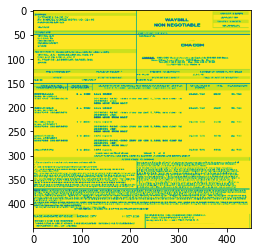

In [17]:
plt.imshow(img[0][0]) 

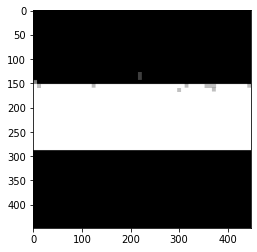

In [18]:
plt.imshow(thresh_table[0][0],cmap='gray') 

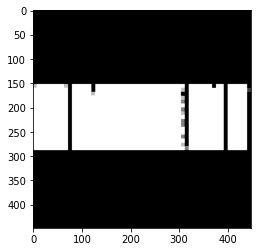

In [ ]:
plt.imshow(thresh_column[0][0],cmap='gray') 

**ALL JUNK BELOW THIS**

In [ ]:
col=np.expand_dims(thresh_column[0][0], axis=2) 

In [ ]:
col=col.astype('float32')*255

In [ ]:
ret,thresh = cv2.threshold(col,254,255,cv2.THRESH_BINARY)

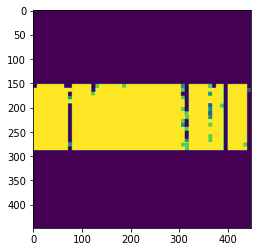

In [ ]:
plt.imshow(thresh)

In [ ]:
thresh = np.uint8(thresh)
contours,hierarchy = cv2.findContours(thresh, 1, 2)
cnt = contours[0]

In [ ]:
boxes_list = []
for cnt in contours:
  x,y,w,h = cv2.boundingRect(cnt)
  boxes_list.append((x,y,w,h))
  if cv2.contourArea(cnt)>10:
    cv2.rectangle(thresh,(x,y),(x+w,y+h),(0,255,0),2)


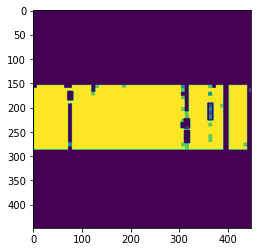

In [ ]:
plt.imshow(thresh)

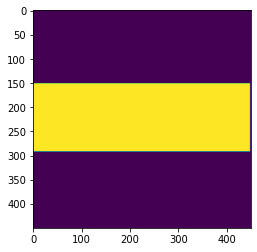

In [ ]:
plt.imshow(mask_table[0])

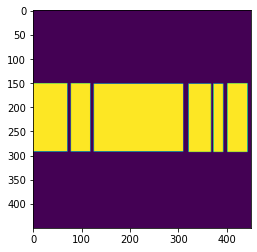

In [ ]:
plt.imshow(mask_column[0])

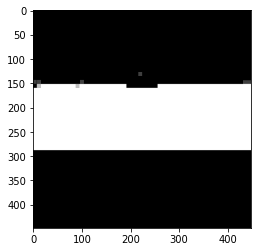

In [ ]:
plt.imshow(thresh_table[0][0],cmap='gray') # 20 epochs on invoice

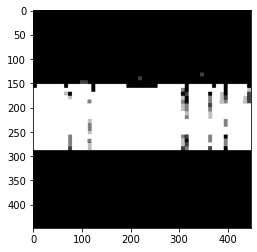

In [ ]:
plt.imshow(thresh_column[0][0],cmap='gray')

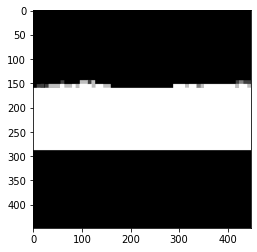

In [ ]:
plt.imshow(thresh_table[0][0],cmap='gray')# 10 epochs on invoice

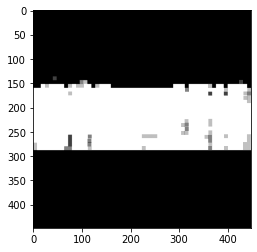

In [ ]:
plt.imshow(thresh_column[0][0],cmap='gray')

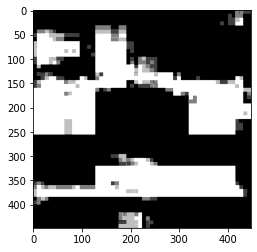

In [ ]:
plt.imshow(thresh_table[0][0],cmap='gray')

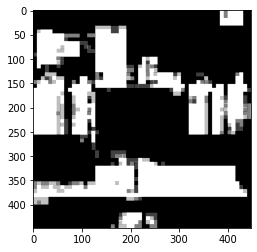

In [ ]:
plt.imshow(thresh_column[0][0],cmap='gray')

In [ ]:
out=table_model(img)

In [ ]:
thresh_table = np.where(out[0]>0.9,1,0)
thresh_column = np.where(out[1]>0.9,1,0)

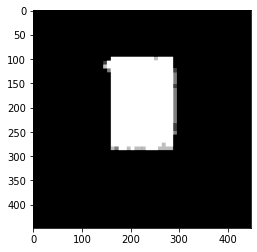

In [ ]:
plt.imshow(thresh_table[0][0],cmap='gray')

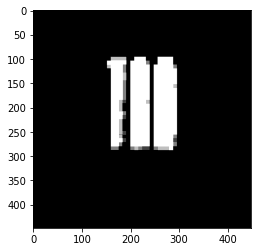

In [ ]:
plt.imshow(thresh_column[0][0],cmap='gray')

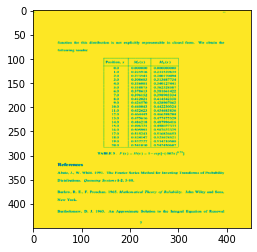

In [ ]:
plt.imshow(img[0][0])

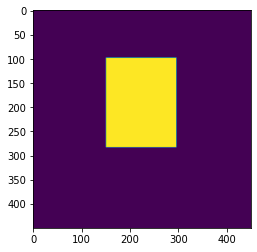

In [ ]:
plt.imshow(mask_table[0])

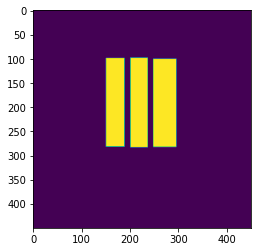

In [ ]:
plt.imshow(mask_column[0])

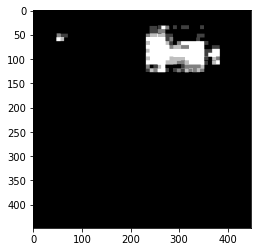

In [ ]:
plt.imshow(thresh_table[0][0],cmap='gray')

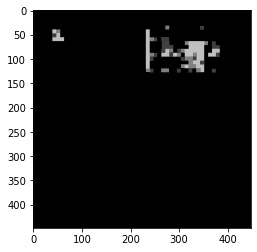

In [ ]:
plt.imshow(thresh_column[0][0],cmap='gray')

In [ ]:
!pip install pytorch-lightning
import pytorch_lightning as pl

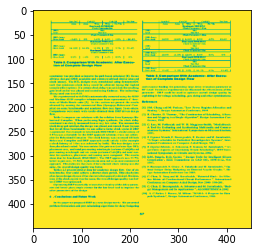

In [ ]:
plt.imshow(img[0][0].detach().numpy())

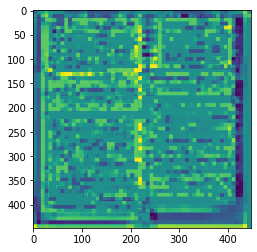

In [ ]:
plt.imshow(out[0][0][0].detach().numpy())

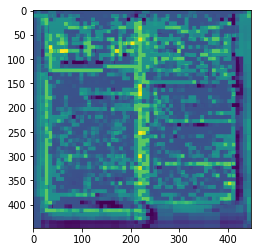

In [ ]:
plt.imshow(out[1][0][0].detach().numpy())

In [ ]:
img,mt,mc=train_dataset[3]

im here
(1056, 816, 3) (1056, 816) (1056, 816)


In [ ]:
model = TableNet(num_class=2)

In [ ]:
img = cv2.resize(img,(1024,1024))

In [ ]:
ten_img=torch.from_numpy(img)

In [ ]:
ten_img.shape

torch.Size([1024, 1024, 3])

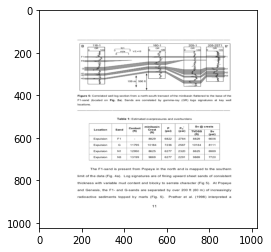

In [ ]:
plt.imshow(img)

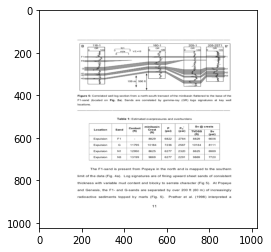

In [ ]:
plt.imshow(ten_img)

In [ ]:
per=ten_img.permute(2,0,1)

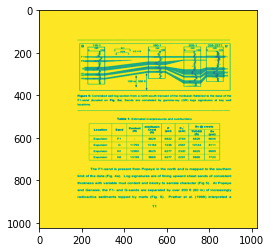

In [ ]:
plt.imshow(per[0])

In [ ]:
result=model(per.unsqueeze(0)*1.)

In [ ]:
result[0].shape

torch.Size([1, 2, 1024, 1024])

In [ ]:
ptm=tm[0][0]

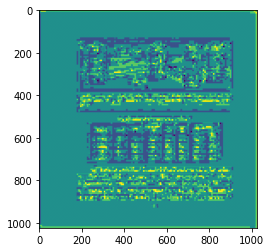

In [ ]:
plt.imshow(ptm.detach().numpy())

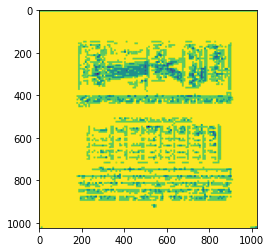

In [ ]:
plt.imshow(cm.detach().numpy()[0][0])